## Using FEDOT for hybrid modeling with custom model tuning

#### FEDOT version = 0.7.5

In [1]:
!pip install fedot==0.7.5

[Original repository on GitHub](https://github.com/nccr-itmo/FEDOT)

This tutorial was prepared by [Natural Systems Simulation Team](https://github.com/ITMO-NSS-team)

--- 

If you want to learn some basic things about FEDOT and time series forecasting, you can use [this notebook](3_intro_ts_forecasting.ipynb).

In [1]:
# Additional imports 
import numpy as np
import pandas as pd
from hyperopt import hp
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# Imports for creating plots
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 18, 7

# Pipeline and nodes
from fedot.core.pipelines.node import PrimaryNode, SecondaryNode
from fedot.core.pipelines.pipeline import Pipeline

# Data
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.data.data import InputData
from fedot.core.data.data_split import train_test_data_setup

# Tasks
from fedot.core.repository.tasks import TaskTypesEnum, Task, TsForecastingParams

#Tuning
from fedot.core.pipelines.tuning.search_space import PipelineSearchSpace
from golem.core.tuning.simultaneous import SimultaneousTuner

import warnings
warnings.filterwarnings('ignore')

import logging
logging.raiseExceptions = False

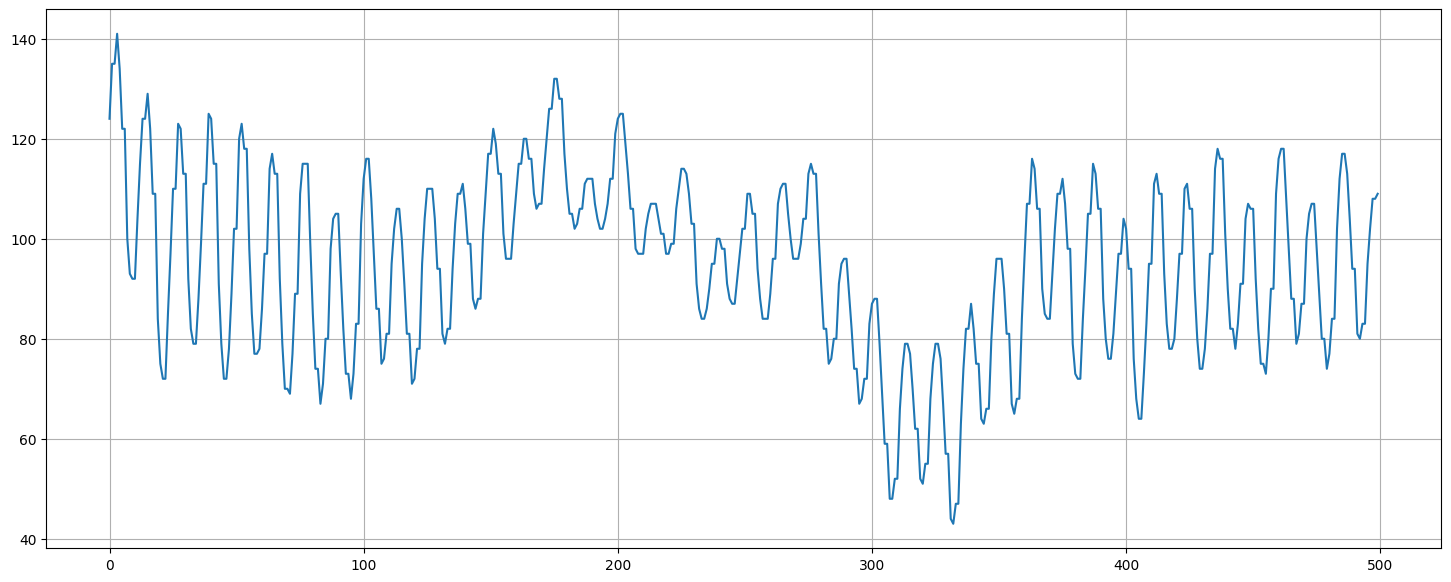

In [2]:
# Read the file
df = pd.read_csv('../data/metocean.csv')

plt.plot(np.arange(len(df['value'])), df['value'])
plt.grid()
plt.show()

# Specify forecast length
len_forecast = 50

# Got univariate time series as numpy array
time_series = np.array(df['value'])

# Wrapp data into InputData
task = Task(TaskTypesEnum.ts_forecasting, TsForecastingParams(forecast_length=len_forecast))

# Split data into train and test
train_input, predict_input = train_test_data_setup(InputData(idx=range(len(time_series)),
                                                                 features=time_series,
                                                                 target=time_series,
                                                                 task=Task(TaskTypesEnum.ts_forecasting,
                                                                           TsForecastingParams(forecast_length=len_forecast)),
                                                                 data_type=DataTypesEnum.ts))

We have a time series of sea level. Based on this time series we will conduct the case of forecasting with custom model implantation in the pipeline.

### Custom model specification

Some custom models have necessary step of fitting, but some of them such as domain specific models doesn't need fitting at all. For using with FEDOT custom model should be wrapped into function that provides fit (if it is necessary) and predict steps. Fit step returns model object, predict step returns predicted values.

In [3]:
# Let's prepare a function for imitation custom model without fitting
def domain_model_imitation_predict(fitted_model: any, idx: np.array, predict_data: np.array, params: dict):
    a = params.get('a')
    b = params.get('b')
    shape = predict_data.shape
    result = np.random.rand(*shape) * a + b
    # Available output_type's 'table', 'ts', 'image', 'text'
    return result, 'table'

# Function for custom regression model imitation (fit)
def custom_ml_model_imitation_fit(idx: np.array, features: np.array, target: np.array, params: dict):
    alpha = params.get('alpha')
    reg = Ridge(alpha=alpha)
    reg.fit(features, target)
    return reg

# Function for custom regression model imitation (predict)
def custom_ml_model_imitation_predict(fitted_model: any, idx: np.array, features: np.array, params: dict):
    res = fitted_model.predict(features)
    return res, 'table'

Including custom model into pipeline is provided by using custom parameters of node. Also there should be indicated parameters of model for tune and initial approximation for them.

In [4]:
# Let's prepare a function for pipeline with custom node without fitting
def get_domain_pipeline():
    """
        Pipeline looking like this
        lagged -> custom -> ridge
    """
    lagged_node = PrimaryNode('lagged')
    lagged_node.parameters = {'window_size': 10}

    # For custom model params as initial approximation and model as function is necessary
    custom_node = SecondaryNode('custom', nodes_from=[lagged_node])
    custom_node.parameters = {"a": -50, "b": 500, 'model_predict': domain_model_imitation_predict}

    node_final = SecondaryNode('ridge', nodes_from=[custom_node])
    pipeline = Pipeline(node_final)

    return pipeline

# Function for pipeline with custom node with fitting
def get_fitting_custom_pipeline():
    """
        Pipeline looking like this
        lagged -> custom -> ridge
    """
    lagged_node = PrimaryNode('lagged')
    lagged_node.parameters = {'window_size': 10}

    # For custom model params as initial approximation and model as function is necessary
    custom_node = SecondaryNode('custom', nodes_from=[lagged_node])
    custom_node.parameters = {'alpha': 5,
                                 'model_predict': custom_ml_model_imitation_predict,
                                 'model_fit': custom_ml_model_imitation_fit}

    node_final = SecondaryNode('lasso', nodes_from=[custom_node])
    pipeline = Pipeline(node_final)

    return pipeline

For pipeline tuning search space of custom model parameters should be specified. Hyperopt wrapper is used for that.

### Function for prediction with/without fitting custom model

In [12]:
from fedot.core.pipelines.tuning.tuner_builder import TunerBuilder
from fedot.core.repository.metrics_repository import \
    MetricsRepository, RegressionMetricsEnum


def run_pipeline_tuning(pipeline_type):

    if pipeline_type == 'with_fit':
        pipeline = get_fitting_custom_pipeline()
        # Setting custom search space for tuner (necessary)
        # model and output_type should be wrapped into hyperopt
        custom_search_space = {
            'custom': {
                'alpha': {
                    'hyperopt-dist': hp.uniform,
                    'sampling-scope': [0.01, 10],
                    'type': 'continuous'
                },
                'model_predict': {
                    'hyperopt-dist': hp.choice,
                    'sampling-scope': [[custom_ml_model_imitation_predict]],
                    'type': 'categorical'
                },
                'model_fit': {
                    'hyperopt-dist': hp.choice,
                    'sampling-scope': [[custom_ml_model_imitation_fit]],
                    'type': 'categorical'
                }
            }
        }
    elif pipeline_type == 'without_fit':
        pipeline = get_domain_pipeline()
        # Setting custom search space for tuner (necessary)
        # model and output_type should be wrapped into hyperopt
        custom_search_space = {
            'custom': {
                'a': {
                    'hyperopt-dist': hp.uniform,
                    'sampling-scope': [-100, 100],
                    'type': 'discrete'
                },
                'b': {
                    'hyperopt-dist': hp.uniform,
                    'sampling-scope': [0, 1000],
                    'type': 'discrete'
                },
                'model_predict': {
                    'hyperopt-dist': hp.choice,
                    'sampling-scope': [[domain_model_imitation_predict]],
                    'type': 'categorical'
                }
            }
        }
    pipeline.fit_from_scratch(train_input)
    pipeline.print_structure()
    # Get prediction with initial approximation
    predicted_before_tuning = pipeline.predict(predict_input).predict

    replace_default_search_space = True

    # Start tuning all nodes in the pipeline 
    tuner = (
        TunerBuilder(train_input.task)
            .with_tuner(SimultaneousTuner)
            .with_metric(RegressionMetricsEnum.MSE)
            .with_iterations(50)
            .with_cv_folds(None)
            .with_validation_blocks(3)
            .with_search_space(PipelineSearchSpace(custom_search_space=custom_search_space,
                                                   replace_default_search_space=replace_default_search_space))
            .build(train_input)
    )
    tuned_pipeline = tuner.tune(pipeline)
    
    # Fit pipeline on the entire train data
    pipeline.fit(train_input)
    # Predict tuned pipeline
    predicted_values = pipeline.predict(predict_input).predict
    pipeline.print_structure()
    return predicted_before_tuning, predicted_values, predict_input.target

def plot_results(predicted_before_tuning, predicted_values, target):
    plt.plot(np.arange(len(predicted_before_tuning)), predicted_before_tuning, label='Before tuning')
    plt.plot(np.arange(len(predicted_values)), predicted_values, label='After tuning')
    plt.plot(np.arange(len(target)), target, label='Real')
    plt.legend()
    plt.grid()
    plt.show()

### Case with using model with fitting 

In [6]:
predicted_before_tuning, predicted_values, target = run_pipeline_tuning(pipeline_type='with_fit')


2025-09-05 19:33:09,828 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
Pipeline structure:
{'depth': 3, 'length': 3, 'nodes': [lasso, custom, lagged]}
lasso - {}
custom - {'alpha': 5, 'model_predict': <function custom_ml_model_imitation_predict at 0x00000200CCA6ADD0>, 'model_fit': <function custom_ml_model_imitation_fit at 0x00000200CCA6AE60>}
lagged - {'window_size': 10}
2025-09-05 19:33:10,377 - DataSourceSplitter - Stratificated splitting of data is disabled.
2025-09-05 19:33:10,380 - DataSourceSplitter - Hold out validation is applied.
2025-09-05 19:33:10,384 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph
2025-09-05 19:33:10,641 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [lasso, custom, lagged]}
lasso - {}
custom - {'alpha': 5, 'model_predict': <function cus

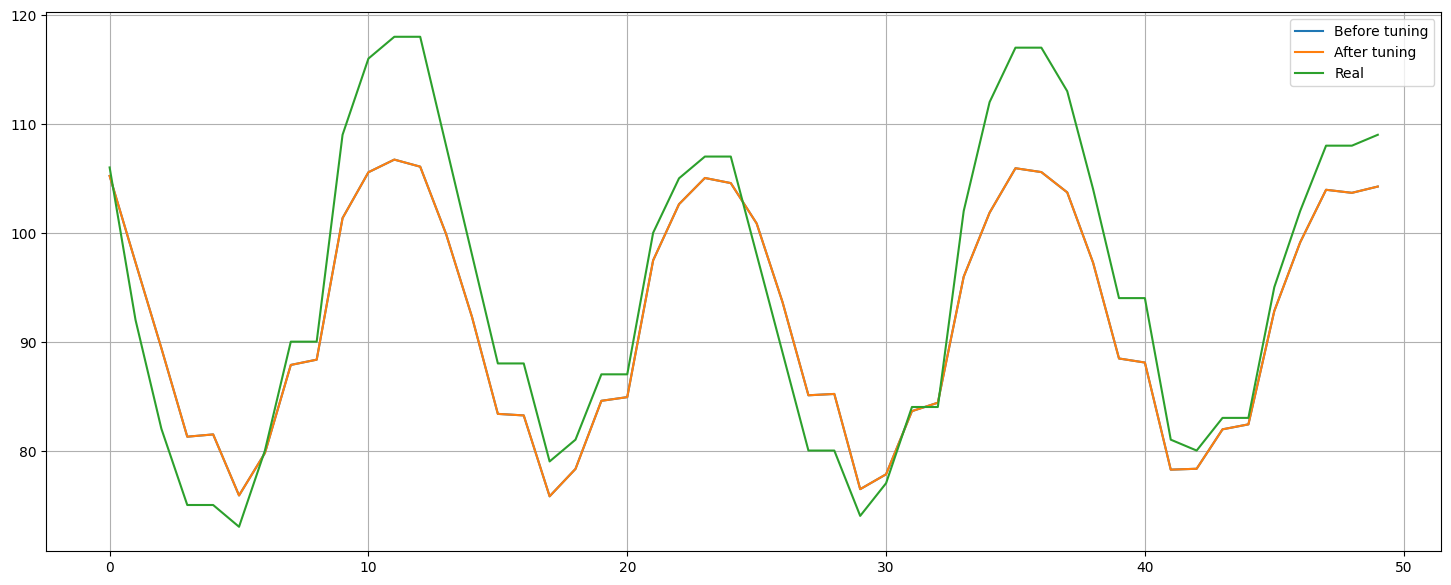

In [13]:
plot_results(predicted_before_tuning, predicted_values, target)

In [14]:
predicted_before_tuning, predicted_values, target = run_pipeline_tuning(pipeline_type='without_fit')


Pipeline structure:
{'depth': 3, 'length': 3, 'nodes': [ridge, custom, lagged]}
ridge - {}
custom - {'a': -50, 'b': 500, 'model_predict': <function domain_model_imitation_predict at 0x00000200CCA6AEF0>}
lagged - {'window_size': 10}
2025-09-05 19:35:23,535 - DataSourceSplitter - Stratificated splitting of data is disabled.
2025-09-05 19:35:23,537 - DataSourceSplitter - Hold out validation is applied.
2025-09-05 19:35:23,539 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph
2025-09-05 19:35:23,558 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 3, 'nodes': [ridge, custom, lagged]}
ridge - {}
custom - {'a': -50, 'b': 500, 'model_predict': <function domain_model_imitation_predict at 0x00000200CCA6AEF0>}
lagged - {'window_size': 10} 
Initial metric: [44899.138]
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]2025-09-05 19:35:23,566 - build_posterior_wrapper took 0.001635 seconds
2025-09-05 19:35:23,568 - TPE using 0 trials
202

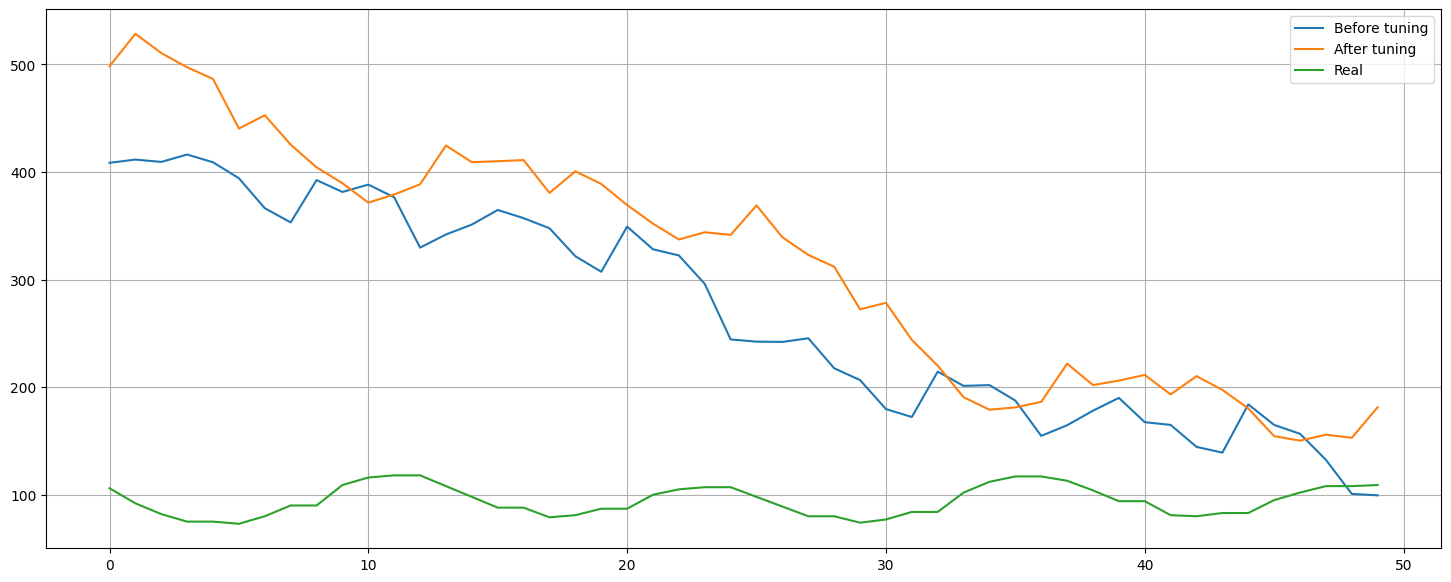

In [15]:
plot_results(predicted_before_tuning, predicted_values, target)

Thus, we demonstrated the use of imitation of custom model with FEDOT for providing the hybrid approach in composition with AutoML.